In [1]:
# import library
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt

import pandas as pd


import joblib

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# import ML model

date = "0627"

ML_model_Llt = joblib.load(f'leakage_inductance_{date}.pkl')
ML_model_Lmt = joblib.load(f'magnetizing_inductance_{date}.pkl')
ML_model_Rt = joblib.load(f'Rt_{date}.pkl')
ML_model_Rr = joblib.load(f'Rr_{date}.pkl')

In [28]:
X = [[9,39,17,94,99,3500,26,26,10,10,6,5,1,3,0,-1]]



X_column = ["N1","w1","l1","l2","h1","per","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]
X_data = pd.DataFrame(X, columns=X_column)
X_data = X_data.astype(float)

Y = X_data.copy()
Y.insert(12, "strand1", 1800)
Y.insert(13, "strand2", 1250)

X_data

,N1,w1,l1,l2,h1,per,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2
0,9.0,39.0,17.0,94.0,99.0,3500.0,26.0,26.0,10.0,10.0,6.0,5.0,1.0,3.0,0.0,-1.0


,load,eff
0,5.0,99.380420
1,6.0,99.482798
2,7.0,99.555788
3,8.0,99.610409
4,9.0,99.652784
...,...,...
90,95.0,99.921642
91,96.0,99.921498
92,97.0,99.921346
93,98.0,99.921188


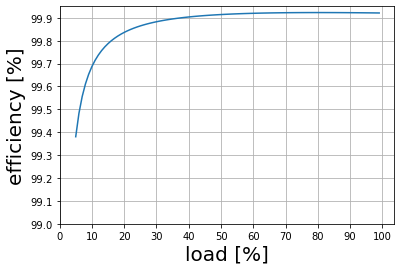

In [114]:
#X = [[9,39,17,94,99,3500,26,26,10,10,6,5,1,3,0,-1]]
#X = [[8,39,22,99,104,3500,24,24,10,11,3.9,4.7,1,1,0,20]]
#X = [[8,48,23,104,103,3500,25,25,13,13,5,7.8,1,1.5,0,-5]]
X = [[7,100,25,100,97,3500,25,25,13,13,5,8,1,1.3,0,-4]]


core_temp = 70

core_a = 0.6942
core_x = 1.4472
core_y = 2.4769
core_b = 4.7948
core_c = 0.0684
core_d = 4e-4
core_LT = core_b - core_c*core_temp + core_d*core_temp**2


X_column = ["N1","w1","l1","l2","h1","per","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]
X_data = pd.DataFrame(X, columns=X_column)
X_data = X_data.astype(float)

Y = X_data.copy()
Y.insert(12, "strand1", 1800)
Y.insert(13, "strand2", 1250)

N1 = X_data["N1"]

w1 = X_data["w1"] * 1e-3
l1 = X_data["l1"] * 1e-3
l2 = X_data["l2"] * 1e-3
h1 = X_data["h1"] * 1e-3

per = X_data["per"]

space1 = X_data["space1"] * 1e-3
space2 = X_data["space2"] * 1e-3
space3 = X_data["space3"] * 1e-3
space4 = X_data["space4"] * 1e-3

coil_width1 = X_data["coil_width1"] * 1e-3
coil_width2 = X_data["coil_width2"] * 1e-3

move_z1 = X_data["move_z1"] * 1e-3
move_z2 = X_data["move_z2"] * 1e-3

offset_z1 = X_data["offset_z1"] * 1e-3
offset_z2 = X_data["offset_z2"] * 1e-3

l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
h = 2*l1 + h1
wp = 1*w1 + 2*space1 + coil_width1
ws = 1*w1 + 2*space3 + coil_width2
w = wp

hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)


V1 = 1036
freq = 30e+3

Lmt = ML_model_Lmt.predict( X_data )

V = l * h * wp

V_core = (2*l1+l2)*h*w1 - l2*h*w1

mag_current = V1/(2*3.141592*freq)/Lmt
Req = N1**2/Lmt
flux = N1 * mag_current/Req
B = flux / (2*w1*l1)


coreloss = []
copperloss_tx = []
copperloss_rx = []
total_loss = []
eff = []
power_p = []


i=0

for power in range(5,100) :

    I1 = power
    I2 = power

    #coreloss.append(6.5 * (freq/1e+3)**1.51 * B**1.74 * V_core / 1e-3)
    coreloss.append(core_a * freq**core_x * B**core_y * core_LT * V_core)

    #copperloss_tx.append(ML_model_Rt.predict( Y ) * I1**2)
    #copperloss_rx.append(ML_model_Rr.predict( Y ) * I2**2)
    copperloss_tx.append(0.003558 * I1**2)
    copperloss_rx.append(0.001271 * I2**2)

    total_loss.append(coreloss[i] + copperloss_tx[i] + copperloss_rx[i])
    eff.append((power*1e+3 - total_loss[i]) / (power*1e+3) * 100)

    i = i+1

    power_p.append(power)

    


plt.plot(power_p,eff)
plt.xlabel("load [%]", fontsize=20)
plt.ylabel("efficiency [%]", fontsize=20)
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(99, 100, 0.1))
plt.grid(True)

X_data = np.concatenate((np.array([power_p]).T,np.array(eff)),axis=1)

X_column = ["load","eff"]
X_data = pd.DataFrame(X_data, columns=X_column)



#X_data.to_csv("./result/eff_power_0628_ferrite.csv")

X_data

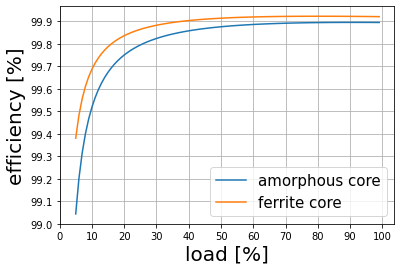

In [118]:
data1 = pd.read_csv("./result/eff_power_0628_amorphous.csv")
data2 = pd.read_csv("./result/eff_power_0628_ferrite.csv")



plt.plot(data1["load"],data1["eff"])
plt.plot(data2["load"],data2["eff"])
plt.xlabel("load [%]", fontsize=20)
plt.ylabel("efficiency [%]", fontsize=20)
plt.xticks(np.arange(0, 110, 10))
plt.yticks(np.arange(99, 100, 0.1))
plt.grid(True)

plt.legend(["amorphous core","ferrite core"], fontsize=15)

In [ ]:

V1 = 1036
I1 = 100
I2 = 100

l = 2*l1 + l2 + space2 + space4 + coil_width1/2 + coil_width2/2
l_inner = space2 + space4 + coil_width1/2 + coil_width2/2
h = 2*l1 + h1
wp = 1*w1 + 2*space1 + coil_width1
ws = 1*w1 + 2*space3 + coil_width2
w = wp

hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)


X_column = ["N1","w1","l1","l2","h1","per","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2"]
X_data = pd.DataFrame(res.X, columns=X_column)
X_data = X_data.astype(float)
#X_data = pd.to_numeric(X_data)


Lmt = ML_model_Lmt.predict( X_data )

V = l * h * wp

V_core = (2*l1+l2)*h*w1 - l2*h*w1

mag_current = V1/(2*3.141592*freq)/Lmt
Req = N1**2/Lmt
flux = N1 * mag_current/Req
B = flux / (2*w1*l1)

#coreloss = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]

coreloss1 = core_a * freq**core_x * B**core_y * core_LT * V_core # Core loss [unit : W]
coreloss2 = 6.5 * (freq/1e+3)**1.51 * B**1.74 * V_core / 1e-3

coreloss = coreloss2

copperloss_tx = ML_model_Rt.predict( X_data ) * I1**2
copperloss_rx = ML_model_Rr.predict( X_data ) * I2**2

total_loss = coreloss + copperloss_tx + copperloss_rx
copperloss = copperloss_tx + copperloss_rx

Llt = ML_model_Llt.predict( X_data )


In [5]:
N1 = 9
coil_width1 = 6
coil_width2 = 6
move_z1 = 1
move_z2 = 1
offset_z1 = 0
offset_z2 = 1

h1 = 84

hp = (N1+1)*coil_width1 + N1*move_z1 + 2*abs(offset_z1)
hs = (N1+1)*coil_width2 + N1*move_z2 + 2*abs(offset_z2)

print(hp)
print(h1-hp)
print(h1-hs)

69
15
13
